In [1]:
from google.colab import drive

# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/ETH.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test với tỉ kệ 5:3:2
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 10s 349ms/step - loss: 2.6754e-04 - val_loss: 0.0779
Epoch 2/100
13/13 [==============================] - 3s 240ms/step - loss: 9.1148e-05 - val_loss: 0.0087
Epoch 3/100
13/13 [==============================] - 3s 220ms/step - loss: 5.1085e-05 - val_loss: 0.0168
Epoch 4/100
13/13 [==============================] - 3s 207ms/step - loss: 4.0347e-05 - val_loss: 0.0082
Epoch 5/100
13/13 [==============================] - 3s 215ms/step - loss: 3.9222e-05 - val_loss: 0.0077
Epoch 6/100
13/13 [==============================] - 4s 276ms/step - loss: 3.4888e-05 - val_loss: 0.0087
Epoch 7/100
13/13 [==============================] - 3s 204ms/step - loss: 3.2829e-05 - val_loss: 0.0066
Epoch 8/100
13/13 [==============================] - 3s 195ms/step - loss: 3.0541e-05 - val_loss: 0.0063
Epoch 9/100
13/13 [==============================] - 2s 194ms/step - loss: 2.8487e-05 - val_loss: 0.0064
Epoch 10/100
13/13 [==============================] - 

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

9/9 [==============================] - 0s 34ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

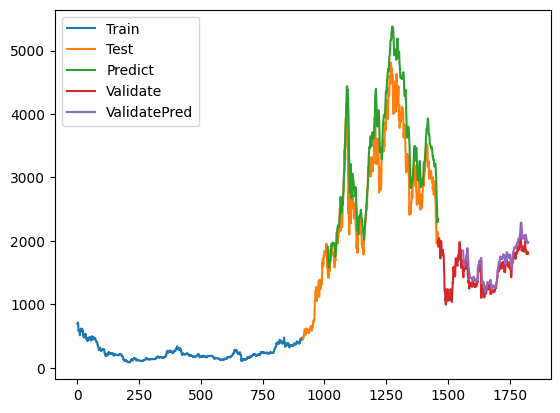

In [13]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [16]:
# Respliting train test
train_size1 = int(0.5 * len(df))
test_size1 = int(0.3 * len(df))
train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]
# Repredictions on the testing set
x_test1 = np.array(test_data1.drop('Price', axis=1))  # Use the features (excluding the target variable)
y_test1 = np.array(test_data1['Price'])

# Repredictions on the validation set
x_val1 = np.array(val_data1.drop('Price', axis=1))  # Use the features (excluding the target variable)
y_val1 = np.array(val_data1['Price'])

In [17]:
# Calculate evalution
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 396.6114843344226
Testing RMSE: 1594.1444552518396
Validation MAPE: 22.452286112041328
Testing MAPE: 86.73355038148998
Validation MAE: 321.8850430017753
Testing MAE: 1273.4864691375294
